# Redshift fitting

Javier Sánchez, 06/09/2016

A big part of the astrophysical and cosmological information comes from geometry, i.e., we can infer a lot of properties of our observable Universe using the positions of stars, galaxies and other objects. The sky appears to us as a 2D projection of our 3D Universe. The angular position can be inferred straightforwardly, however, how far away is one object from us given its angular coordinates is quite challenging and encodes very valuable information.

A simple way to compute the distance between us and a light source is by measuring its redshift $z$. If the source emits at wavelength $\lambda_{em}$ and is observed by us at wavelength $\lambda_{obs}$, $z$ is given by:

$$z = \lambda_{obs}/\lambda_{em}-1$$

We saw this in Chapter 8.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time

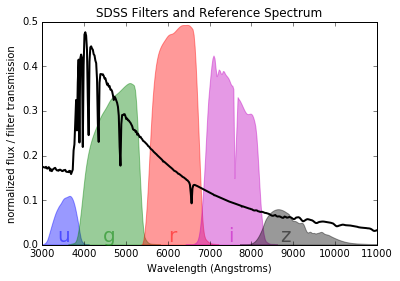

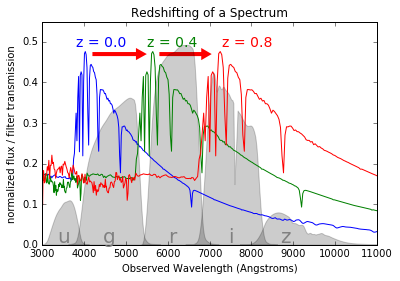

In [3]:
import os
import urllib2

import numpy as np
import pylab as pl
from matplotlib.patches import Arrow

REFSPEC_URL = 'http://www.astro.washington.edu/users/ivezic/DMbook/data/1732526_nic_002.ascii'
URL = 'http://www.sdss.org/dr7/instruments/imager/filters/%s.dat'

def fetch_filter(filt):
    assert filt in 'ugriz'
    url = URL % filt
    
    if not os.path.exists('downloads'):
        os.makedirs('downloads')

    loc = os.path.join('downloads', '%s.dat' % filt)
    if not os.path.exists(loc):
        print "downloading from %s" % url
        F = urllib2.urlopen(url)
        open(loc, 'w').write(F.read())

    F = open(loc)
        
    data = np.loadtxt(F)
    return data

def fetch_vega_spectrum():
    if not os.path.exists('downloads'):
        os.makedirs('downloads')

    refspec_file = os.path.join('downloads', REFSPEC_URL.split('/')[-1])

    if  not os.path.exists(refspec_file):
        print "downloading from %s" % REFSPEC_URL
        F = urllib2.urlopen(REFSPEC_URL)
        open(refspec_file, 'w').write(F.read())

    F = open(refspec_file)

    data = np.loadtxt(F)
    return data


Xref = fetch_vega_spectrum()
Xref[:, 1] /= 2.1 * Xref[:, 1].max()

#----------------------------------------------------------------------
# Plot filters in color with a single spectrum
pl.figure()
pl.plot(Xref[:, 0], Xref[:, 1], '-k', lw=2)

for f,c in zip('ugriz', 'bgrmk'):
    X = fetch_filter(f)
    pl.fill(X[:, 0], X[:, 1], ec=c, fc=c, alpha=0.4)

kwargs = dict(fontsize=20, ha='center', va='center', alpha=0.5)
pl.text(3500, 0.02, 'u', color='b', **kwargs)
pl.text(4600, 0.02, 'g', color='g', **kwargs)
pl.text(6100, 0.02, 'r', color='r', **kwargs)
pl.text(7500, 0.02, 'i', color='m', **kwargs)
pl.text(8800, 0.02, 'z', color='k', **kwargs)

pl.xlim(3000, 11000)

pl.title('SDSS Filters and Reference Spectrum')
pl.xlabel('Wavelength (Angstroms)')
pl.ylabel('normalized flux / filter transmission')

#----------------------------------------------------------------------
# Plot filters in gray with several redshifted spectra
pl.figure()

redshifts = [0.0, 0.4, 0.8]
colors = 'bgr'

for z, c in zip(redshifts, colors):
    pl.plot((1. + z) * Xref[:, 0], Xref[:, 1], color=c)

pl.gca().add_patch(Arrow(4200, 0.47, 1300, 0, lw=0, width=0.05, color='r'))
pl.gca().add_patch(Arrow(5800, 0.47, 1250, 0, lw=0, width=0.05, color='r'))

pl.text(3800, 0.49, 'z = 0.0', fontsize=14, color=colors[0])
pl.text(5500, 0.49, 'z = 0.4', fontsize=14, color=colors[1])
pl.text(7300, 0.49, 'z = 0.8', fontsize=14, color=colors[2])

for f in 'ugriz':
    X = fetch_filter(f)
    pl.fill(X[:, 0], X[:, 1], ec='k', fc='k', alpha=0.2)

kwargs = dict(fontsize=20, color='gray', ha='center', va='center')
pl.text(3500, 0.02, 'u', **kwargs)
pl.text(4600, 0.02, 'g', **kwargs)
pl.text(6100, 0.02, 'r', **kwargs)
pl.text(7500, 0.02, 'i', **kwargs)
pl.text(8800, 0.02, 'z', **kwargs)

pl.xlim(3000, 11000)
pl.ylim(0, 0.55)

pl.title('Redshifting of a Spectrum')
pl.xlabel('Observed Wavelength (Angstroms)')
pl.ylabel('normalized flux / filter transmission')

pl.show()

### Idea: Measure light at different wavelengths from the sources to determine their redshift

### Spectra

If we measure the spectra at different wavelengths with certain resolution we can compare with an object with the same characteristics and a known redshift and compute it.

### Photometry

Instead of using a spectrograph we use filters and take images of the objects to build a low resolution spectrum and infer the redshfit.

Photometry has the advantage of speed: we can measure more objects simultaneously. The problem is that these objects have very low resolution spectra (5 points across the 3000-10000 Angstroms for SDSS, DES and LSST) range. Spectroscopy gives a way higher resolution ($\lambda/\Delta \lambda$ ~ 1500 in BOSS at 3800 Angstroms and 2500 at 9000 Angstroms $\Rightarrow$ ~ 2.5/3.6 Angstroms pixels. 1 Angstrom pixels for DESI), the problem is that it requires more time.

## Redsfhit fitting techniques

There are a lot of different options to retrieve the redshift information from an astronomical source. All of them have their advantages and disadvantages and depend on the nature of the data.

For spectra, the most usual technique is to compare with a collection of spectral templates and minimize a $\chi^{2}$. For example, in SDSS-III/BOSS a PCA analysis is performed and then a $\chi^{2}$ minimization of the principal components (http://www.sdss.org/dr12/algorithms/redshifts/  --  http://arxiv.org/pdf/1207.7326v2.pdf).

Other approaches:
 
 * Cross-correlation with templates
 * Emission line fitting
 * Pure $\chi^{2}$
 * Bayesian (bayez)
 
For photometric redshifts there is a wider variety of methods given that the number of inputs is lower and thus, a ML approach is easier to treat:
 
 * Artificial Neural Networks [Multilayer perceptron] (ANNz/Skynet)
 * Random forests/Boosted Decision Trees (TPZ/ArborZ)
 * Bayesian (BPZ)
 * $\chi^{2}$ minimization using templates (LePhare)
 * Nearest neighbors (KNN)
 * Gaussian processes (http://arxiv.org/pdf/1505.05489v3.pdf)
 * Linear regression/polynomial regression (outdated)

## Examples

### Linear regression

/Users/javiers/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


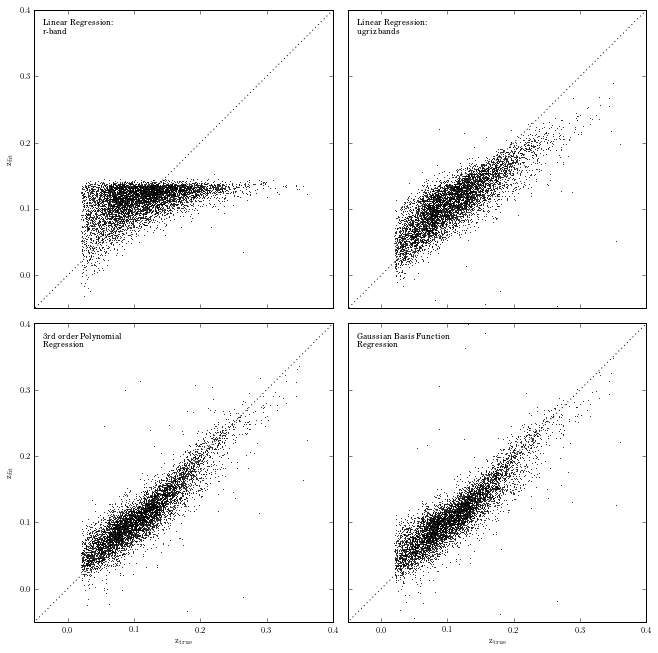

In [4]:
"""
Photometric Redshifts via Linear Regression
-------------------------------------------
Linear Regression for photometric redshifts
We could use sklearn.linear_model.LinearRegression, but to be more
transparent, we'll do it by hand using linear algebra.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import itertools


from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import euclidean_distances

from astroML.datasets import fetch_sdss_specgals

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

np.random.seed(0)

data = fetch_sdss_specgals()

# put magnitudes in a matrix
# with a constant (for the intercept) at position zero
mag = np.vstack([np.ones(data.shape)]
                + [data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


def plot_results(z, z_fit, plotlabel=None,
                 xlabel=True, ylabel=True):
    plt.scatter(z, z_fit, s=1, lw=0, c='k')
    plt.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
    plt.xlim(-0.05, 0.4001)
    plt.ylim(-0.05, 0.4001)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.1))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))

    if plotlabel:
        plt.text(0.03, 0.97, plotlabel,
                 ha='left', va='top', transform=ax.transAxes)

    if xlabel:
        plt.xlabel(r'$\rm z_{true}$')
    else:
        plt.gca().xaxis.set_major_formatter(plt.NullFormatter())

    if ylabel:
        plt.ylabel(r'$\rm z_{fit}$')
    else:
        plt.gca().yaxis.set_major_formatter(plt.NullFormatter())


def combinations_with_replacement(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    for indices in itertools.product(range(n), repeat=r):
        if sorted(indices) == list(indices):
            yield tuple(pool[i] for i in indices)


def poly_features(X, p):
    """Compute polynomial features
    Parameters
    ----------
    X: array_like
        shape (n_samples, n_features)
    p: int
        degree of polynomial
    Returns
    -------
    X_p: array
        polynomial feature matrix
    """
    X = np.asarray(X)
    N, D = X.shape
    ind = list(combinations_with_replacement(range(D), p))
    X_poly = np.empty((X.shape[0], len(ind)))

    for i in range(len(ind)):
        X_poly[:, i] = X[:, ind[i]].prod(1)

    return X_poly


def gaussian_RBF_features(X, centers, widths):
    """Compute gaussian Radial Basis Function features
    Parameters
    ----------
    X: array_like
        shape (n_samples, n_features)
    centers: array_like
        shape (n_centers, n_features)
    widths: array_like
        shape (n_centers, n_features) or (n_centers,)
    Returns
    -------
    X_RBF: array
        RBF feature matrix, shape=(n_samples, n_centers)
    """
    X, centers, widths = map(np.asarray, (X, centers, widths))
    if widths.ndim == 1:
        widths = widths[:, np.newaxis]
    return np.exp(-0.5 * ((X[:, np.newaxis, :]
                           - centers) / widths) ** 2).sum(-1)

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.05, wspace=0.05,
                    left=0.1, right=0.95,
                    bottom=0.1, top=0.95)

#----------------------------------------------------------------------
# first do a simple linear regression between the r-band and redshift,
# ignoring uncertainties
ax = plt.subplot(221)
X_train = mag_train[:, [0, 3]]
X_test = mag_test[:, [0, 3]]
z_fit = LinearRegression().fit(X_train, z_train).predict(X_test)
plot_results(z_test, z_fit,
             plotlabel='Linear Regression:\n r-band',
             xlabel=False)

#----------------------------------------------------------------------
# next do a linear regression with all bands
ax = plt.subplot(222)
z_fit = LinearRegression().fit(mag_train, z_train).predict(mag_test)
plot_results(z_test, z_fit, plotlabel="Linear Regression:\n ugriz bands",
             xlabel=False, ylabel=False)

#----------------------------------------------------------------------
# next do a 3rd-order polynomial regression with all bands
ax = plt.subplot(223)
X_train = poly_features(mag_train, 3)
X_test = poly_features(mag_test, 3)
z_fit = LinearRegression().fit(X_train, z_train).predict(X_test)
plot_results(z_test, z_fit, plotlabel="3rd order Polynomial\nRegression")

#----------------------------------------------------------------------
# next do a radial basis function regression with all bands
ax = plt.subplot(224)

# remove bias term
mag = mag[:, 1:]
mag_train = mag_train[:, 1:]
mag_test = mag_test[:, 1:]

centers = mag[np.random.randint(mag.shape[0], size=100)]
centers_dist = euclidean_distances(centers, centers, squared=True)
widths = np.sqrt(centers_dist[:, :10].mean(1))

X_train = gaussian_RBF_features(mag_train, centers, widths)
X_test = gaussian_RBF_features(mag_test, centers, widths)
z_fit = LinearRegression().fit(X_train, z_train).predict(X_test)
plot_results(z_test, z_fit, plotlabel="Gaussian Basis Function\nRegression",
             ylabel=False)

plt.show()

### Decision trees

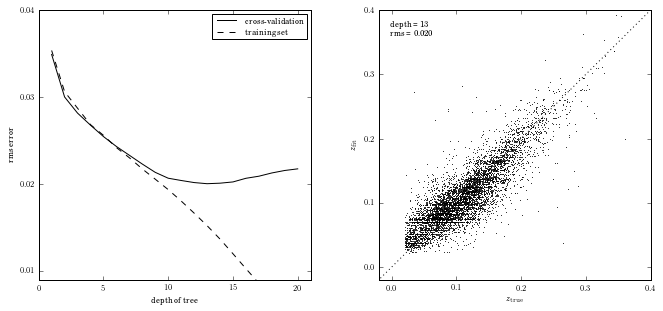

In [5]:
"""
Photometric Redshifts by Decision Trees
---------------------------------------
Figure 9.14
Photometric redshift estimation using decision-tree regression. The data is
described in Section 1.5.5. The training set consists of u, g , r, i, z
magnitudes of 60,000 galaxies from the SDSS spectroscopic sample.
Cross-validation is performed on an additional 6000 galaxies. The left panel
shows training error and cross-validation error as a function of the maximum
depth of the tree. For a number of nodes N > 13, overfitting is evident.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from sklearn.tree import DecisionTreeRegressor
from astroML.datasets import fetch_sdss_specgals

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Fetch data and prepare it for the computation
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 separate points
mag_test = mag[1::100]
z_test = z[1::100]

#------------------------------------------------------------
# Compute the cross-validation scores for several tree depths
depth = np.arange(1, 21)
rms_test = np.zeros(len(depth))
rms_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

for i, d in enumerate(depth):
    clf = DecisionTreeRegressor(max_depth=d, random_state=0)
    clf.fit(mag_train, z_train)

    z_fit_train = clf.predict(mag_train)
    z_fit = clf.predict(mag_test)
    rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
    rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

    if rms_test[i] <= rms_test[i_best]:
        i_best = i
        z_fit_best = z_fit

best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# first panel: cross-validation
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.legend(loc=1)

# second panel: best-fit results
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

### Boosted decision trees

@pickle_results: using precomputed results from 'photoz_boosting.pkl'


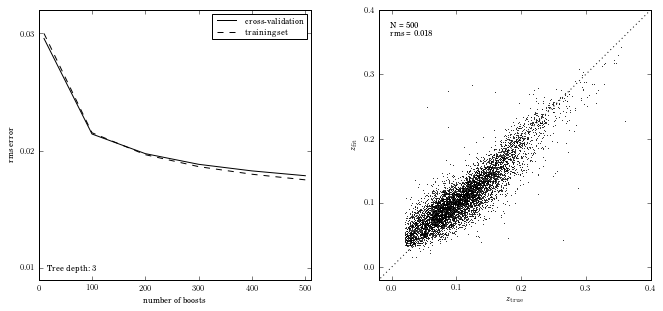

In [6]:
"""
Photometric Redshifts by Random Forests
---------------------------------------
Figure 9.16
Photometric redshift estimation using gradient-boosted decision trees, with 100
boosting steps. As with random forests (figure 9.15), boosting allows for
improved results over the single tree case (figure 9.14). Note, however, that
the computational cost of boosted decision trees is such that it is
computationally prohibitive to use very deep trees. By stringing together a
large number of very naive estimators, boosted trees improve on the
underfitting of each individual estimator.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from sklearn.ensemble import GradientBoostingRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.decorators import pickle_results


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_boosting.pkl')
def compute_photoz_forest(N_boosts):
    rms_test = np.zeros(len(N_boosts))
    rms_train = np.zeros(len(N_boosts))
    i_best = 0
    z_fit_best = None

    for i, Nb in enumerate(N_boosts):
        try:
            # older versions of scikit-learn
            clf = GradientBoostingRegressor(n_estimators=Nb, learn_rate=0.1,
                                            max_depth=3, random_state=0)
        except TypeError:
            clf = GradientBoostingRegressor(n_estimators=Nb, learning_rate=0.1,
                                            max_depth=3, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best

N_boosts = (10, 100, 200, 300, 400, 500)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(N_boosts)
best_N = N_boosts[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(N_boosts, rms_test, '-k', label='cross-validation')
ax.plot(N_boosts, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('number of boosts')
ax.set_ylabel('rms error')
ax.set_xlim(0, 510)
ax.set_ylim(0.009,  0.032)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax.text(0.03, 0.03, "Tree depth: 3",
        ha='left', va='bottom', transform=ax.transAxes)

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "N = %i\nrms = %.3f" % (best_N, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

### KNN

RMS error = 0.024


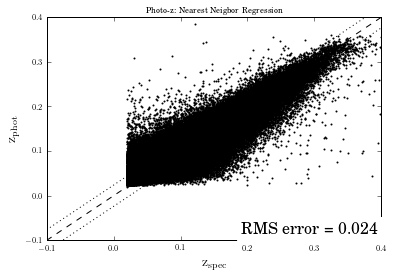

In [7]:
"""
K-Neighbors for Photometric Redshifts
-------------------------------------
Estimate redshifts from the colors of sdss galaxies and quasars.
This uses colors from a sample of 50,000 objects with SDSS photometry
and ugriz magnitudes.  The example shows how far one can get with an
extremely simple machine learning approach to the photometric redshift
problem.
The function :func:`fetch_sdss_galaxy_colors` used below actually queries
the SDSS CASjobs server for the colors of the 50,000 galaxies.
"""
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure is an example from astroML: see http://astroML.github.com

from sklearn.neighbors import KNeighborsRegressor
from astroML.plotting import scatter_contour
n_neighbors=10
N = len(data)

# shuffle data
np.random.seed(0)
np.random.shuffle(data)

# put colors in a matrix
X = np.zeros((N, 4))
X[:, 0] = data['modelMag_u'] - data['modelMag_g']
X[:, 1] = data['modelMag_g'] - data['modelMag_r']
X[:, 2] = data['modelMag_r'] - data['modelMag_i']
X[:, 3] = data['modelMag_i'] - data['modelMag_z']
z = data['z']

# divide into training and testing data
Ntrain = N // 2
Xtrain = X[:Ntrain]
ztrain = z[:Ntrain]

Xtest = X[Ntrain:]
ztest = z[Ntrain:]

knn = KNeighborsRegressor(n_neighbors, weights='distance')
zpred = knn.fit(Xtrain, ztrain).predict(Xtest)

axis_lim = np.array([-0.1, 0.4])

rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print("RMS error = %.2g" % rms)

ax = plt.axes()
plt.scatter(ztest, zpred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)

plt.text(0.99, 0.02, "RMS error = %.2g" % rms,
         ha='right', va='bottom', transform=ax.transAxes,
         bbox=dict(ec='w', fc='w'), fontsize=16)

plt.title('Photo-z: Nearest Neigbor Regression')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)
plt.show()

### Neural Network

In this case I am going to use a Recurrent Neural Network (Long Short Term Memory). More info on: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [8]:
from keras.models import Sequential
model = Sequential()
from keras.layers import Dense, Activation
from keras.layers.recurrent import GRU, SimpleRNN
from keras.layers.recurrent import LSTM
from keras.layers import Embedding
model.add(LSTM(64,input_dim=4, return_sequences=False, activation='tanh'))
model.add(Dense(64))
model.add(Dense(32, init='normal', activation='tanh'))
model.add(Dense(16, init='normal', activation='tanh'))
model.add(Dense(8))
model.add(Dense(4, init='normal', activation='tanh'))
model.add(Dense(1, init='normal'))
model.compile(loss='mse', optimizer='rmsprop')

Using Theano backend.


In [19]:
#model.train_on_batch(X[:60000].reshape(60000,4,1), z[:60000])
batch_size=60000
model.fit(X[:batch_size].reshape(-1,1,4), z[:batch_size], batch_size=batch_size, nb_epoch=300, verbose=0, validation_split=0.5)

In [20]:
test_size=6000
predicted_output = model.predict_on_batch(X[batch_size:batch_size+test_size].reshape(-1,1,4))

(array([  2.00000000e+00,   1.20000000e+01,   1.66000000e+02,
          1.34600000e+03,   2.32100000e+03,   1.20700000e+03,
          5.98000000e+02,   2.69000000e+02,   7.30000000e+01,
          6.00000000e+00]),
 array([-0.06894316, -0.02954888,  0.0098454 ,  0.04923968,  0.08863396,
         0.12802824,  0.16742252,  0.20681679,  0.24621107,  0.28560535,
         0.32499963]),
 <a list of 10 Patch objects>)

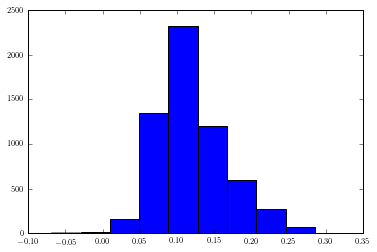

In [21]:
plt.hist(predicted_output)

(6000,)
(661598,)


0.02615226984024048

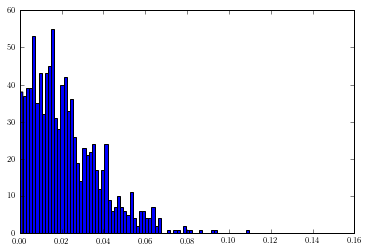

In [22]:
print predicted_output[:,0].shape
print z.shape
diff = np.sqrt((predicted_output[:1000,0]-z[batch_size:1000+batch_size])**2)
plt.hist(diff, bins=100, range=(0,0.15));
np.percentile(diff,68)

RMS error = 0.072


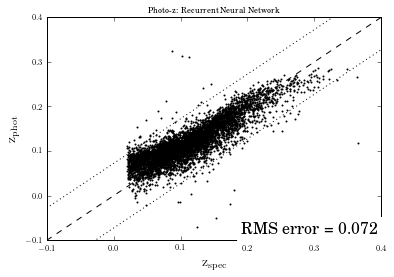

In [23]:
axis_lim = np.array([-0.1, 0.4])

rms = np.sqrt(np.mean((predicted_output - z[batch_size:batch_size+test_size]) ** 2))
print("RMS error = %.2g" % rms)

ax = plt.axes()
plt.scatter(z[batch_size:batch_size+test_size], predicted_output, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)

plt.text(0.99, 0.02, "RMS error = %.2g" % rms,
         ha='right', va='bottom', transform=ax.transAxes,
         bbox=dict(ec='w', fc='w'), fontsize=16)

plt.title('Photo-z: Recurrent Neural Network')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)
plt.show()

Long short-term memory units (LSTMs): One challenge affecting RNNs is that early models turned out to be very difficult to train, harder even than deep feedforward networks. The reason is the unstable gradient problem discussed in Chapter 5. Recall that the usual manifestation of this problem is that the gradient gets smaller and smaller as it is propagated back through layers. This makes learning in early layers extremely slow. The problem actually gets worse in RNNs, since gradients aren't just propagated backward through layers, they're propagated backward through time. If the network runs for a long time that can make the gradient extremely unstable and hard to learn from. Fortunately, it's possible to incorporate an idea known as long short-term memory units (LSTMs) into RNNs. The units were introduced by Hochreiter and Schmidhuber in 1997 with the explicit purpose of helping address the unstable gradient problem. LSTMs make it much easier to get good results when training RNNs, and many recent papers (including many that I linked above) make use of LSTMs or related ideas.

Extracted from (http://neuralnetworksanddeeplearning.com/chap6.html)


## Bayez (D. Kirkby, J. Sánchez, N. Kennamer) (https://github.com/dkirkby/bayez)

Bayez is a bayesian redshift estimator of spectroscopic data. It estimates the redshift given the spectra and the object type (STAR, QSO, ELG, LRG). Optionally it can use magnitude information to improve the accuracy. What we compute using bayez is:

$$ P(z| D, M, C) = \int\int d\theta dm P(\theta,m,z|D,M,C) = P(D, M |C)^{-1} F(z) $$

Where $z$ is the redshift, $D$ the spectral information, $M$ the magnitude information, $C$ the object type/class, $m$ the magnitude, and $\theta$ other class parameters.

$$ F(z) = \int \int d\theta dm P(D,M|\theta,m,z) P(\theta, m,z|C) $$

$P(D,M|\theta,m,z) \Leftrightarrow$ likelihood,

$P(\theta, m,z|C) \Leftrightarrow$ prior (Luminosity function)

$$P(D,M|C) = \int dz F(z)$$


We generate a large number of priors called "exemplars" (we simulate them using the specsim package: https://github.com/desihub/specsim) and perform a MC estimate of the multidimensional integral. An advantage is that flux normalization (magnitude change) are fast to perform and we can separate the integral as follows:

$$ F(z) \approx \frac{1}{N_{s}} \delta_{D}(z-z_{i})\int dm P(D,M|m,i)P(m|i)$$

Where $i=1,2,...,N_{s}$ are the samples (simulated templates)

Bayez then compares with the library of templates and computes the likelihood $e^{-\chi^{2}/2}$. The package supports downsampling the spectra (it accelerates the estimation) and performs the $\chi^{2}$ calculation in each part of the spectra before coadding (DESI has 3 cameras b,r,z covering different wavelength ranges)

### Example of usage: https://github.com/dkirkby/bayez/blob/master/docs/nb/BayezExamples.ipynb

### Performance: https://github.com/dkirkby/bayez/blob/master/docs/nb/BayezResults.ipynb

### Pros and cons of this approach

#### Pros: It can be as precise as your simulations. Having realistic simulations/templates allows you to have very precise results. It is fast and highly parallel. You can use the full posterior for your analysis (as opposed to point estimators)
#### Cons: It is limited by the accuracy of your simulations/templates (as good as your templates). As for now it needs prior information on the object type (we haven't implemented an object classifier yet).

It is intended to be used in DESI. We are taking part on the redshift data challenge -- We have to estimate the redshift from visually inspected eBOSS spectra (Noble)

We might port the code to use it in GPU